In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import time
import pandas as pd 
import os
import numpy as np

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1723983452.533478    2750 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723983452.771109    2750 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723983452.771218    2750 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
class CLM():
    def __init__(self, layers, n_chars, dropouts, trainables,lr):
        self.layers = layers
        self.n_chars = n_chars
        self.dropouts = dropouts
        self.trainables = trainables
        self.lr = lr
        self.model = None
        self.build_model()
    def build_model(self):
        # create a squential model and assigned to self.model
        self.model = Sequential()
        # Add a BatchNormalization layer input layer, input shape should be None, number of characters
        self.model.add(BatchNormalization(input_shape = (None,self.n_chars)))
        
        # Add n LSTM layers, where n is defined by the variable layers. This will be a list of ints where each int is the number of units in the LSTM layer. i.e [256, 512] will add two layers with 256 and 512 neurons respectively
        # This loop should also include the dropout values contained in the dropouts variable (list of floats). 
        # And it should also include the trainable parameter from the trainables variable (list of booleans). 
        print(self.layers)
        for i in range(len(self.layers)):
            print(self.layers[i])
            self.model.add(LSTM(units=self.layers[i], trainable=self.trainables[i], return_sequences=True, dropout=self.dropouts[i]))
            
        # add another BatchNormalization layer, this time no need to specify input shape
        self.model.add(BatchNormalization())
        # Finally add an output layer, it should be a Dense layer with n_chars units and softmax activation. Also, this layer should be containd in a TimeDistributed layer, so that it can be applied to each character in the sequence.
        self.model.add(TimeDistributed(Dense(self.n_chars, activation='softmax')))
        # compile the model with Adam optimizer and categorical_crossentropy loss. Don't forget to set the learning rate to the value contained in the lr variable with optimizer = Adam(learning_rate=self.lr)
        optimizer = Adam(learning_rate=self.lr)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [4]:
import re
import numpy as np
import keras

#Fixed parameters
PROCESSING_FIXED = {'start_char': 'G', 
                    'end_char': 'E', 
                    'pad_char': 'A'}

INDICES_TOKEN = {0: 'c',
                 1: 'C',
                 2: '(',
                 3: ')',
                 4: 'O',
                 5: '1',
                 6: '2',
                 7: '=',
                 8: 'N',
                 9: '@',
                 10: '[',
                 11: ']',
                 12: 'n',
                 13: '3',
                 14: 'H',
                 15: 'F',
                 16: '4',
                 17: '-',
                 18: 'S',
                 19: 'Cl',
                 20: '/',
                 21: 's',
                 22: 'o',
                 23: '5',
                 24: '+',
                 25: '#',
                 26: '\\',
                 27: 'Br',
                 28: 'P',
                 29: '6',
                 30: 'I',
                 31: '7',
                 32: PROCESSING_FIXED['start_char'],
                 33: PROCESSING_FIXED['end_char'],
                 34: PROCESSING_FIXED['pad_char']}                
TOKEN_INDICES = {v: k for k, v in INDICES_TOKEN.items()}

def smi_tokenizer(smi):
    """
    Tokenize a SMILES
    """
    pattern =  "(\[|\]|Xe|Ba|Rb|Ra|Sr|Dy|Li|Kr|Bi|Mn|He|Am|Pu|Cm|Pm|Ne|Th|Ni|Pr|Fe|Lu|Pa|Fm|Tm|Tb|Er|Be|Al|Gd|Eu|te|As|Pt|Lr|Sm|Ca|La|Ti|Te|Ac|Si|Cf|Rf|Na|Cu|Au|Nd|Ag|Se|se|Zn|Mg|Br|Cl|U|V|K|C|B|H|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%\d{2}|\d)"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]

    return tokens        

class onehotencoder():
    def __init__(self, max_chars=90):
        # here we define the class variables that will be used in the functions. If we want to use them in the class, we need to use self. in front of the variable name
        # then when we want to use the class variable in the function, we pass self as the first argument to the function and we can access the class variables
        self.max_chars = max_chars
    def smiles_to_num(self, smiles):
        tokens = smi_tokenizer(smiles)
        tokens = [PROCESSING_FIXED['start_char']] + tokens +[PROCESSING_FIXED['end_char']]
        tokens+= [PROCESSING_FIXED['pad_char']]* (self.max_chars-len(tokens))
        num_tokens = [TOKEN_INDICES[t] for t in tokens]
        #print(tokens)
        #create numbers
        return np.asarray(tokens) #Return the numbers as a numpy array
    def num_to_onehot(self,tokens):
        onehot = np.zeros((len(tokens), len(INDICES_TOKEN)))
        for i,token in enumerate(tokens):
            onehot[i, TOKEN_INDICES[token]] = 1
        return onehot
        #This function will convert the numbers to one hot encoding. It should take a list of numbers and return a list of one hot encoded vectors with the shape (max_chars, 35)
    def generate_data(self, smiles):
        nums = self.smiles_to_num(smiles)
        data = self.num_to_onehot(nums)
        return np.asarray(data)
        #This function should take a list of smiles strings and return a numpy array of one hot encoded vectors with the shape (number of smiles, max_chars, 35)
        #You can use the smiles_to_num and num_to_onehot functions to help you with this
        #This function will be used to generate the training and validation data

        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size, data, max_len, num_chars, use_multiprocessing=True, workers=6, shuffle=True):
        super().__init__(use_multiprocessing=use_multiprocessing, workers=workers)
        'Initialization'
        self.encoder = onehotencoder(max_chars=max_len)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.data = data
        self.num_chars = num_chars
        self.max_len = max_len
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.max_len-1, self.num_chars))
        y = np.empty((self.batch_size, self.max_len-1, self.num_chars))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            smiles = self.data[ID]
            one_hot_smi = self.encoder.generate_data(smiles)
            X[i] = one_hot_smi[:-1]
            y[i] = one_hot_smi[1:]
        return X, y
    def tester(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.max_len-1, self.num_chars))
        y = np.empty((self.batch_size, self.max_len-1, self.num_chars))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            smiles = self.data[ID]
            one_hot_smi = self.encoder.generate_data(smiles)
            X[i] = one_hot_smi[:-1]
            y[i] = one_hot_smi[1:]
        return X, y
    #You can give this a try with the tutorial and see if you can get it to work https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    #This will be used to generate the data for the model. It should take a list of smiles strings and the corresponding labels and return the one hot encoded vectors in batches
    #You can use the onehotencoder class to help you with this.
    #It is important to follow the function signature of the keras.utils.Sequence class so that it can be used with the model.fit_generator function
    #This is al detailed in the tutorial above

In [5]:
#load the data from data/us_pharma_patent_data_lowe_smiles_can_unique_stereochem.txt
data = pd.read_csv('data/us_pharma_patent_data_lowe_smiles_can_unique_stereochem.txt', sep='\t', header=None)
#Remember to drop missing values and duplicates
data = data.dropna().drop_duplicates()
#Also, remove any smiles string that contains a character NOT in our vocabulary (excluding pad, start and end chars). Hint: allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
data = data[data[0].apply(lambda x: all(char in allowed_chars for char in x))]
#drop data longer than 90 characters
data = data[data[0].apply(lambda x: len(x)<=90)]
#Split the data into train and test sets with a 80/20 split. Don't forget to reset the index of the dataframes before splitting, so then we can use the train.index and test.index to create the generators
data = data.reset_index(drop=True)
#train_data, test_data = train_test_split(data, test_size=0.2)


In [6]:
#np.savetxt( 'data/train_data_idx.txt',np.array(train_data.index))
#np.savetxt('data/test_data_idx.txt', np.array(test_data.index))

In [7]:
train_idx = np.loadtxt('data/train_data_idx.txt')
test_idx = np.loadtxt('data/test_data_idx.txt')

In [8]:
#Initialize the generators, we need one for training and one for validation. Use batch size of 256 for both. Remember to pass all the data to them, but the corresponding indices. Also the data should be passed as a list of strings, so don't forget to use the .tolist() method on the dataframe column

#confused about variables
train_generator = DataGenerator(
    data = data[0],
    max_len = 92,
    batch_size=256,
    list_IDs=train_idx,
    num_chars=35
)

validation_generator = DataGenerator(
    data = data[0],
    max_len = 92,
    batch_size=256,
    list_IDs=test_idx,
    num_chars=35
)

In [9]:
#Here are some predefine hyperparameters (taken from the paper which are already optimize, lucky us!)
layers = [1024,256]
dropouts = [0.40, 0.40]
trainables = [True, True]
lr = 0.001
epochs = 40

In [10]:
#Create a checkpointer callback that saves the model weights to a file every epoch. The filename should be '{epoch:03d}.weights.h5'
checkpointer = ModelCheckpoint(
    filepath='LSTM/{epoch:03d}.keras',
    #save_weights_only=True,
    save_freq='epoch'
)

In [11]:
# Define monitoring
monitor = 'val_loss'
lr_reduction = ReduceLROnPlateau(monitor=monitor, 
                                     patience=3, 
                                     verbose=0, 
                                     factor=0.5, 
                                     min_lr=0.00005)

In [12]:
initial_epoch = 39 #Set the epoch to restart from

In [13]:
#Create the model object from the CLM class or load checkpoint if it exists
if not os.path.exists(f'LSTM/{initial_epoch:03d}.keras'):
    chem_model = CLM(
    layers=layers,
    dropouts=dropouts,
    trainables=trainables,
    lr=lr,
    n_chars=35
    )
    print('model created')
else:
    chem_model = load_model(f'LSTM/{initial_epoch:03d}.keras') #load the model from file
    checkpoint_resume = True
   # print('lr is ', K.get_session().run(model.optimizer.lr))

#not sure why I am getting dimension error?

I0000 00:00:1723561858.614793   13466 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723561858.615109   13466 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723561858.615163   13466 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723561860.207569   13466 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723561860.207726   13466 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13

In [14]:
if checkpoint_resume:
    chem_model.summary()
else:
    chem_model.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, None, 35)       │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 1024)     │     4,341,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 256)      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 35)       │         8,995 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,989,827 (64.81 MB)

 Trainable params: 5,663,081 (21.60 MB)

 Non-trainable params: 582 (2.27 KB)

 Optimizer params: 11,326,164 (43.21 MB)

In [22]:
#Do training! (pass the generators instead of the data directly) 
if checkpoint_resume:
    hist = chem_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[checkpointer,lr_reduction], initial_epoch=initial_epoch)
else:
    hist = chem_model.model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[checkpointer,lr_reduction])

Epoch 40/40


2024-08-13 15:36:59.417253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1910/1910 ━━━━━━━━━━━━━━━━━━━━ 317s 160ms/step - loss: 0.3805 - val_loss: 0.3884 - learning_rate: 0.0010


In [ ]:
val_loss = []
for i in range(40):
    print('epoch', i+1)
    chem_model = load_model(f'LSTM/{i+1:03d}.keras')
    loss = chem_model.evaluate(validation_generator)
    print(loss)
    val_loss.append(loss)

In [19]:
np.savetxt('LSTM/val_loss_0-40.txt', np.array(val_loss))

In [ ]:
#Print best loss
print('Best loss:', min(val_loss), 'Epoch:', np.argmin(val_loss))


In [ ]:
train_loss = []
for i in range(40):
    print('epoch', i+1)
    chem_model = load_model(f'LSTM/{i+1:03d}.keras')
    loss = chem_model.evaluate(train_generator)
    print(loss)
    train_loss.append(loss)


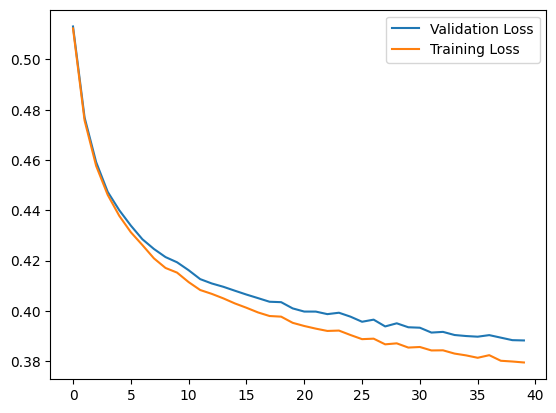

In [5]:
import matplotlib.pyplot as plt
val_loss = np.loadtxt('LSTM/val_loss_0-40.txt')
train_loss = np.loadtxt('LSTM/train_loss_0-40.txt')
plt.plot(val_loss, label='Validation Loss')
plt.plot(train_loss, label='Training Loss')
plt.legend()
plt.show()